# Plagiarism detector

## Project Setup

To start the project, let's set the reference path of the notebook to the root of the project. In that way, it will be easier to deal with filepaths whenever necessary. Also, let's configure log level INFO message.

In [1]:
import os
import pathlib
path = os.path.join(pathlib.Path().absolute(), '../')
os.chdir(path)

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format="%(levelname)s:%(message)s", level=logging.INFO)

## Load and prepare the data

The first step of course is to load the data. The loading procedure involves iterating through the dataset folder and aggregating labels and records. In the project, for each candidate answer, there are 6 LLM answers and similarity scores between each LLM answer and the candidate answer. 

So, we are going to approach this, as if we have 6 different records. For example, for the first code challenge question, we have the following structure:

```markdown
./dataset
├── CodeAid Source Codes Labeling.xlsx
├── dataset-source-codes
    ├── source_code_000
        ├── source_code_000.json
        ├── source_code_000.java
        ├── source_code_000_gpt-3.5-turbo_00.java
        ├── source_code_000_gpt-3.5-turbo_01.java
        ├── source_code_000_gpt-4_00.java
        ├── source_code_000_gpt-4_01.java
        ├── source_code_000_gpt-4-turbo_00.java
        ├── source_code_000_gpt-4-turbo_01.java
    
```

As you can see, for `source_code_000`, the candidate answer is in the `source_code_000.java`, while there are 6 gpt answers in the other files. Thus, what we meant previously was that we are going to structure the dataset for the problem not as a single datapoint, but as six. Therefore, the dataset records generated for the source_code_000, for example, is something in the lines of:

| candidate source code | LLM source code | plagiariasm score |
|-----------------------|-----------------|-------------------|
| source_code_000.java | source_code_000_gpt-3.5-turbo_00.java | 0.0 | 
| source_code_000.java | source_code_000_gpt-3.5-turbo_01.java | 0.0 | 
| source_code_000.java | source_code_000_gpt-4_00.java | 0.0 | 
| source_code_000.java | source_code_000_gpt-4_01.java | 0.0 | 
| source_code_000.java | source_code_000_gpt-4-turbo_00.java | 0.0 | 
| source_code_000.java | source_code_000_gpt-4-turbo_01.java | 0.0 |

Ok, now we are in good shape to actually do that.

In [2]:
import os
import re
import json
import pandas as pd
from pandas import DataFrame
from typing import List, Dict, Any

import matplotlib.pyplot as plt
import seaborn as sns

In [297]:
def read_file(file_path: str) -> str:
    with open(file_path, 'r') as file:
        return file.read()
    
def list_files_with_regex(folder_path: str, pattern: str) -> List[str]:
    matched_files = []
    regex = re.compile(pattern)

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if regex.match(file):
                matched_files.append(os.path.join(root, file))

    return matched_files

def load_data(dataset_path: str, label: DataFrame) -> Dict[str, Any]:
    data = {
        'coding_problem_id': [],
        'coding_question': [],
        'candidate_answer': [],
        'llm_answer_id': [],
        'llm_answer': [],
        'plagiarism_score': [],
        "programming_language": []
    }

    for index, row in label.iterrows():
        problem_id = row['coding_problem_id']
        llm_answer_id = row['llm_answer_id']
        plagiarism_score = row['plagiarism_score']

        folder = os.path.join(dataset_path, problem_id)
        
        json_file_path = os.path.join(folder, f'{problem_id}.json')
        with open(json_file_path, 'r') as json_file:
            coding_question = json.load(json_file)['question']
        
        # identify code file extensions
        pattern = fr'{problem_id}\..*'  # Example pattern
        matched_files = list_files_with_regex(folder, pattern)
        file_code_extension = [file.split(".")[-1] for file in matched_files if file.split(".")[-1] != "json"][0]
                
        candidate_base_path = os.path.join(folder, problem_id)
        candidate_file_path = f"{candidate_base_path}.{file_code_extension}"
        candidate_answer = read_file(candidate_file_path)

        # Find the LLM's code file with any of the possible extensions
        llm_base_path = os.path.join(folder, f'{problem_id}_{llm_answer_id}')
         
        llm_file_path = f"{llm_base_path}.{file_code_extension}"
        llm_answer = read_file(llm_file_path)

        data['coding_problem_id'].append(problem_id)
        data['coding_question'].append(coding_question)
        data['candidate_answer'].append(candidate_answer)
        data['llm_answer_id'].append(llm_answer_id)
        data['llm_answer'].append(llm_answer)
        data['plagiarism_score'].append(plagiarism_score)
        data["programming_language"].append(file_code_extension)

    return data

In [298]:
# Path to the dataset folder containing source codes
dataset_path = './dataset/dataset-source-codes'

# Load the labels from the Excel file
labels = pd.read_excel('./dataset/CodeAid Source Codes Labeling.xlsx', sheet_name='v3')

data = load_data(dataset_path, labels)

Once, we've successfully load the data into the desired format, we can convert it to an appropriate format to huggingface models. 

In [300]:
from datasets import Dataset, DatasetDict
dataset = DatasetDict({'data': Dataset.from_dict(data)})

In [301]:
data_df = DataFrame(data)
data_df.tail()

,coding_problem_id,coding_question,candidate_answer,llm_answer_id,llm_answer,plagiarism_score,programming_language
373,source_code_062,Create a PHP script that will accept a string ...,<?php\nfunction getTopThreeWords($text) {\n// ...,gpt-3.5-turbo_01,<?php\n\nfunction findTopThreeWords($input) {\...,0.3,php
374,source_code_062,Create a PHP script that will accept a string ...,<?php\nfunction getTopThreeWords($text) {\n// ...,gpt-4_00,function findTopWords($input) {\n // Remove...,0.3,php
375,source_code_062,Create a PHP script that will accept a string ...,<?php\nfunction getTopThreeWords($text) {\n// ...,gpt-4_01,<?php\n function mostCommonWords($input) {\...,0.3,php
376,source_code_062,Create a PHP script that will accept a string ...,<?php\nfunction getTopThreeWords($text) {\n// ...,gpt-4-turbo_00,<?php\n\nfunction getTopThreeWords($text) {\n ...,0.3,php
377,source_code_062,Create a PHP script that will accept a string ...,<?php\nfunction getTopThreeWords($text) {\n// ...,gpt-4-turbo_01,<?php\n\n// Function to get the top three most...,0.3,php


### Data Analysis 

As a warm up, let's do some quick data analysis just to know the dataset better. Usually, it's good practice to analyse the data over the training set to avoid "being too smart" and somehow get a glimpse of the evaluation dataset, which could potentially bias our analysis. However, since here we are going to use pre-trained models to accomplish our task and we have only a couple tens of records, let's make this exception.

First, let's count the frequency of programming languages per code challenge:

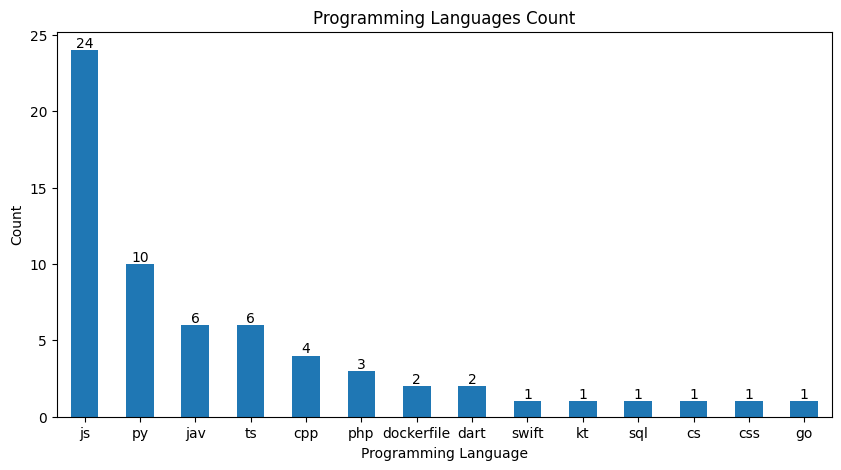

In [320]:
# dividing by 6 to account for duplicate programming language rows
programming_languages_counts = (data_df["programming_language"].value_counts() / 6).astype(int)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

programming_languages_counts.plot(kind='bar', ax=ax)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.title('Programming Languages Count')
plt.xlabel('Programming Language')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

The most frequent programming languages are JavaScript (plus TypeScript), Python, Java, C++, PHP. Other programming languages contributes very little to the volume of the dataset. 

Let's shift gears and study the distribution of plagiarism scores:

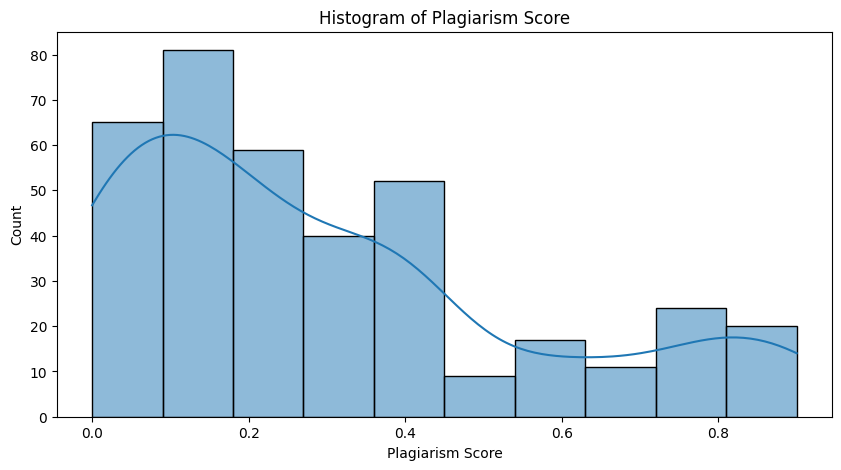

In [339]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.histplot(data=data_df, x='plagiarism_score', bins=10, discrete=False, kde=True, ax=ax)

plt.title('Histogram of Plagiarism Score')
plt.xlabel('Plagiarism Score')
plt.ylabel('Count')
plt.show()

As we can see, the labels are bimodal, and most of the times, the amount of potential plagiarism detected is slow. This might be a problem for the model we are going to develop later, because that indicates that there are only relatively few samples with strong signals. Thus, the model is going to have a harder time trying to read the data patterns.

Now, let's examine the data from the perspective of the size (in characters) of the answers provided by the candidates and the LLMs.

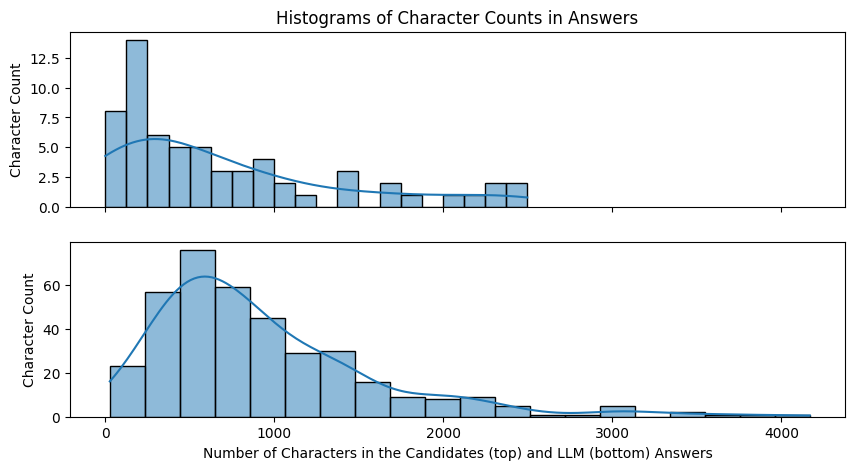

In [354]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

candidate_answer_len = data_df["candidate_answer"].drop_duplicates().apply(len).to_frame()
sns.histplot(data=candidate_answer_len, x='candidate_answer', bins=20, discrete=False, kde=True, ax=ax[0])

llm_answer_len = data_df["llm_answer"].drop_duplicates().apply(len).to_frame()
sns.histplot(data=llm_answer_len, x='llm_answer', bins=20, discrete=False, kde=True, ax=ax[1])

ax[0].set_title('Histograms of Character Counts in Answers')
ax[0].set_xlabel('')  # Remove x label for the first histogram

ax[0].set_ylabel('Character Count')

ax[1].set_xlabel('Number of Characters in the Candidates (top) and LLM (bottom) Answers')
ax[1].set_ylabel('Character Count')
plt.show()

As we can see, the answers provided by the LLMs tend to be bigger in character count. This may happen for some reasons such as code comments or docstrings. It also indicates that 1:1 correspondences between candidates answers and LLM answers may be unlikely.

Ok, now let's focus on building a plagiarism detector.

## Building a baseline model

Before properly tackling the problem, it's good practice to create a baseline model so we can compare it against the model we are going to obtain later. There isn't a closed formula for how to set baselines. It usually requires common sense and gut feeling. For our purposes here, it may be enough to do some cosine similarity between embeddings of the candidates and LLM answers. Let's see how it goes.

To vectorize the dataset, we are going to use a pre-trained model from HuggingFace. Of course, we could use any model, like BERT, for example, but conveniently there exist a pre-trained model for Programming and Natural Languages: codeBERT \[[1](https://huggingface.co/microsoft/codebert-base), [2](https://arxiv.org/abs/2002.08155)\]. 

The primary dataset used to train codeBERT consists of 2 million (comment, code) pairs from open source libraries. Concretely, a comment is a top-level function or method comment (e.g. docstrings in Python), and code is an entire function or method. Currently, the dataset contains Python, Javascript, Ruby, Go, Java, and PHP code \[[3](https://github.com/github/CodeSearchNet?tab=readme-ov-file#data)\].

codeBERT was pre-trained over texts from the main programming languages present in our dataset. In spite of it not being trained over all programming languages we need to deal with, this may not be a problem because there aren't many samples from programming languages other than the ones covered during the codeBERT pre-training. Moreover, programming languages share syntax similarities and structure that may be identified anyways by codeBERT.

So, let's build our baseline model.

In [186]:
import torch
import torch.nn.functional as F

from torch import Tensor

from transformers import AutoModel, AutoTokenizer, PreTrainedTokenizerBase
from transformers.tokenization_utils_base import BatchEncoding


In [7]:
model_ckpt = 'microsoft/codebert-base' 

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [8]:
tokenizer.vocab_size, tokenizer.model_max_length, tokenizer.model_input_names

(50265, 512, ['input_ids', 'attention_mask'])

In [18]:
def tokenize(batch: Dict[str, Any], tokenizer: PreTrainedTokenizerBase, target: str) -> BatchEncoding:
    return tokenizer(batch[target], padding=True, truncation=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

The output of `model(**inputs)` has shape `[batch_size, n_tokens, hidden_dim]`. Thus, there is a hidden_dim-dimensional vector for each token. Note that the first and last tokens are marks for the beginning and end of sentence, [CLS] and [SEP].

In [189]:
def extract_hidden_states(batch: BatchEncoding) -> Dict[str, Tensor]:
    # place model inputs on the GPU
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    
    # extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    # aggregate all token embeddings with the mean
    return {"hidden_state": last_hidden_state.cpu().mean(dim=1)}

In [190]:
candidate_answers_batch = tokenizer(data["candidate_answer"], padding=True, truncation=True, return_tensors="pt")
llm_answers_batch = tokenizer(data["llm_answer"], padding=True, truncation=True, return_tensors="pt")

In [191]:
candidate_hidden_states = extract_hidden_states(candidate_answers_batch)
llm_hidden_states = extract_hidden_states(llm_answers_batch)

In [193]:
# Normalize the tensors for cosine similarity
candidate_answers_embed = F.normalize(candidate_hidden_states["hidden_state"], p=2, dim=1)
llm_answers_embed = F.normalize(llm_hidden_states["hidden_state"], p=2, dim=1)

# Cosine Similarity
cosine_similarity = F.cosine_similarity(candidate_answers_embed, llm_answers_embed)
similarity_metric = (cosine_similarity + 1) / 2

## Evaluation metrics

Some key methods and metrics are considered when evaluating a model that is trained over soft labels and outputs some comparable similarity metric. Let 

- $n$ is the number of samples
- $y_i$ is the soft label (interpreted as the true extento to which the candidate code answers was generated by an LLM)
- $p_i$ is the similarity measure (interpreted as the probabibility that the candidate code answers was generated by an LLM inferred by the model)

For this problem, we are going to evaluate the models with respect to the following metrics:

1. **Log Loss (Cross-Entropy Loss)**

    For soft labels, the log loss can be calculated as:
    
    $\text{Log Loss} = -\frac{1}{n} \sum_{i=1}^{n} y_{i} \log(p_{i}) + (1 - y_{i}) \log(1 - p_{i}) $, where 


    the log loss is unbounded but ideally, we desired it to be as close to 0 as it can gets.

2. **Kullback-Leibler Divergence (KL Divergence)**

    KL divergence measures how one probability distribution diverges from a second, expected probability distribution. For evaluating soft labels, the KL divergence can be used as:

    $KL(Y \parallel P) = \sum_{i=1}^{n} y_{i} \log \frac{y_{i}}{p_{i}} + (1 - y_{i}) \log \frac{1 - y_{i}}{1 - p_{i}}$, where $n$, $y_i$, and $p_i$ can be interpreted as aforementioned.

    a KL divergence of 0 means that the conditional distributions of P and Y are the same. So, our goal here is to find a model that minimizes KL divergence.

3. **Brier Score**

    Evaluating how well the predicted probabilities are calibrated can be important. Brier score is one such metric, adapting its formula for soft labels, we get:

    $\text{Brier Score} = \frac{1}{n} \sum_{i=1}^{n} (p_i - y_i)^2 + [(1-p_i) - (1-y_i)]^2$

    the denominator is an adaptation to properly scale the score taking into account the symmetry of the probability differences.

4. **Calibration Diagram**

    The calibration diagram can be thought as a Reliability Diagram. Originally, reliability diagrams are used in the context of binary classification with hard labels. But since we are using soft labels here, let's adopt the name "calibration diagram" name to avoid confusion.

    A Calibration diagram can be thought as a graphical tool to analyse and inspect how much the predicted similarity probabilities are close to each other. The x-axis represent the true probability and the y-axis represent the predicted probabilities. Ideally, we want the model probability to match the true similarity score, so in the graph we use a black-dashed diagonal line to represent the ideal scenario. Data points over this line are overestimated predictions, and under the line are underestimated predictions.

<!-- Reference: -->
<!-- kl divergence -->
<!-- [1](https://math.stackexchange.com/questions/2604566/kl-divergence-between-two-multivariate-bernoulli-distribution#:~:text=The%20KL%20divergence%20between%20two%20such%20distributions%20is%20DK,z)q(z).) -->

<!-- brier score -->
<!-- https://medium.com/sigmaeffe-ml/brier-score-mean-squared-error-for-classification-f655c0948eab -->

<!-- reliability diagram -->
<!-- https://towardsdatascience.com/introduction-to-reliability-diagrams-for-probability-calibration-ed785b3f5d44 -->

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [256]:
def log_loss(predictions: Tensor, soft_labels: Tensor) -> Tensor:
    """
    Compute the log loss (cross-entropy loss) for soft labels.
    
    Args:
    predictions (torch.Tensor): Predicted probabilities.
    soft_labels (torch.Tensor): Soft labels (target distributions).
    
    Returns:
    torch.Tensor: Log loss (float).
    """
    epsilon = 1e-15
    log_loss = -torch.sum(soft_labels * torch.log(predictions + epsilon) + (1 - soft_labels) * torch.log(1 - predictions + epsilon)) / predictions.size(0)
    return log_loss


def kl_divergence(predictions: Tensor, soft_labels: Tensor) -> Tensor:
    """
    Compute the KL divergence between predicted probabilities and soft labels.
    
    Args:
    predictions (torch.Tensor): Predicted probabilities.
    soft_labels (torch.Tensor): Soft labels (target distributions).
    
    Returns:
    torch.Tensor: KL divergence (float).
    """
    epsilon = 1e-15
    kl_div = torch.sum(
        soft_labels * torch.log((soft_labels + epsilon) / (predictions + epsilon)) +
        (1 - soft_labels) * torch.log((1 - soft_labels + epsilon) / (1 - predictions + epsilon))
        ) / predictions.size(0)
    
    return kl_div


def brier_score(predictions: Tensor, soft_labels: Tensor) -> Tensor:
    """
    Compute the Brier score for predicted probabilities and soft labels.
    
    Args:
    predictions (torch.Tensor): Predicted probabilities.
    soft_labels (torch.Tensor): Soft labels (target distributions).
    
    Returns:
    torch.Tensor: Brier score (float).
    """
    brier = torch.sum(
        (predictions - soft_labels) ** 2 + 
        ((1 - predictions) - (1 - soft_labels)) ** 2,
        ) / predictions.size(0)
    return brier

In [261]:
def plot_calibration_diagram(predictions, soft_labels):
    
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Create a scatter plot
    ax.scatter(x=soft_labels, y=predictions, s=8)

    # Add a diagonal black dashed line from (0, 0) to (1, 1)
    ax.plot([0, 1], [0, 1], ls="--", color="black", label="Perfect Calibration")

    # Add a regression line using seaborn
    sns.regplot(x=soft_labels, y=predictions, scatter=False, ax=ax, ci=None, color="blue", label="Regression Line: $p_i$ vs $y_i$")
    
    # Add the shaded area below the diagonal line
    ax.fill_between([0, 1], [0, 1], color="lightblue", alpha=0.5)

    # Add the text "Underestimation zone" in the middle of the shaded area
    ax.text(0.75, 0.25, "Underestimation zone", horizontalalignment='center', verticalalignment='center', fontsize=10, color='black', weight='bold')
    
    # Add the shaded area above the diagonal line
    ax.fill_between([0, 1], [0, 1], [1, 1], color="lightcoral", alpha=0.5)
    
    # Add the text "Overestimation zone" in the middle of the shaded area above the line
    ax.text(0.25, 0.75, "Overestimation zone", horizontalalignment='center', verticalalignment='center', fontsize=10, color='black', weight='bold')

    ax.legend()

    # Add titles and labels
    ax.set_title('Calibration Diagram: True Similarity Scores vs Predicted')
    ax.set_xlabel('True Probability of Plagiarism')
    ax.set_ylabel('Predicted Probability of Plagiarism')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Show the plot
    plt.show()

### Baseline model Evaluation

In [267]:
baseline_predictions = similarity_metric
plagiarism_scores = Tensor(data_df["plagiarism_score"])

In [289]:
metrics = DataFrame(data=[["Baseline", 
                           log_loss(baseline_predictions, plagiarism_scores).numpy(),
                           kl_divergence(baseline_predictions, plagiarism_scores).numpy(),
                           brier_score(baseline_predictions, plagiarism_scores).numpy()]], 
                    columns=["Model", "Log-Loss", "KL Divergence", "Brier Score"])

In [290]:
metrics

,Model,Log-Loss,KL Divergence,Brier Score
0,Baseline,2.4341607,2.0156503,0.97693676


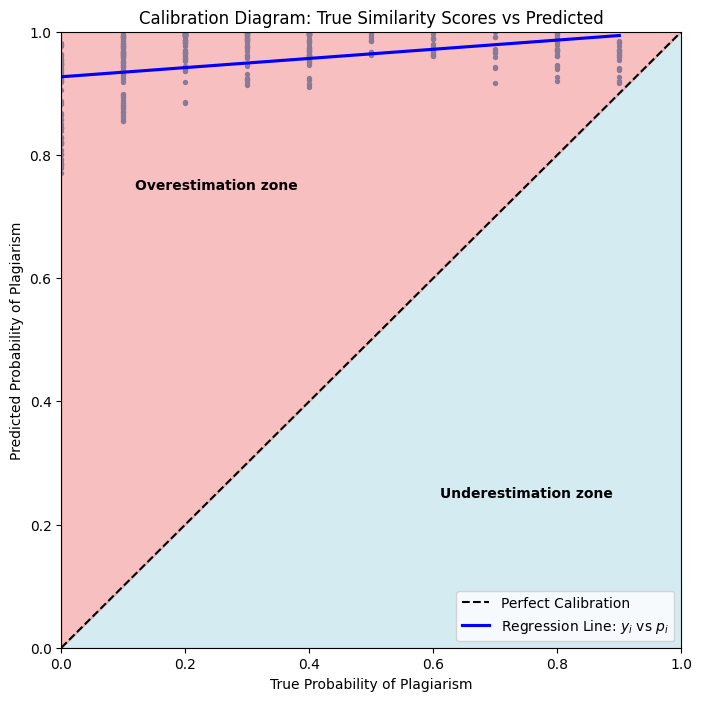

In [293]:
plot_calibration_diagram(baseline_predictions.numpy(), plagiarism_scores.numpy())

## Approaching the problem as a classification problem

In [10]:
from datasets import Dataset, DatasetDict
from transformers import TrainingArguments, Trainer
from transformers.trainer_utils import PredictionOutput
import numpy as np
from transformers import AutoModelForSequenceClassification
import torch
from transformers import AutoTokenizer, PreTrainedTokenizerBase

def tokenize(batch: Dict[str, Any], tokenizer: PreTrainedTokenizerBase) -> Dict[str, Any]:
    return tokenizer(batch["candidate_answer"], batch["llm_answer"], padding=True, truncation=True)

# Prepare the final datasets for training
def prepare_dataset(dataset):
    return {
        'input_ids': dataset['input_ids'],
        'attention_mask': dataset['attention_mask'],
        'labels': dataset['plagiarism_score']
    }
    
def compute_metrics(pred: PredictionOutput):
    labels = pred.label_ids
    preds = pred.predictions
    preds = torch.sigmoid(torch.tensor(preds)).squeeze().numpy()
    # labels = labels.astype(np.float32)
    bce_loss = torch.nn.functional.binary_cross_entropy(torch.tensor(preds), torch.tensor(labels)).item()
    
    return {
        'bce_loss': bce_loss
    }

model_ckpt = 'microsoft/codebert-base'  # https://arxiv.org/abs/2002.08155

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Apply tokenization
dataset_encoded = dataset.map(lambda batch: tokenize(batch, tokenizer=tokenizer), batched=True, batch_size=None)

# Split the tokenized dataset into training and validation sets
train_size = 0.8
data_split = dataset_encoded['data'].train_test_split(test_size=1 - train_size, seed=42)

train_dataset = data_split['train']
test_dataset = data_split['test']

train_dataset = Dataset.from_dict(prepare_dataset(train_dataset))
test_dataset = Dataset.from_dict(prepare_dataset(test_dataset))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 1
batch_size = 8

model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)).to(device)

logging_steps = len(train_dataset) // batch_size
model_name = f"{model_ckpt}-finetuned-plagiarism-detector"

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=2e-5,
    num_train_epochs=4,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps,
    logging_dir='./logs',
    log_level="error",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Map:   0%|          | 0/378 [00:00<?, ? examples/s]

Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

  0%|          | 0/152 [00:00<?, ?it/s]

{'loss': 0.0856, 'learning_rate': 1.5131578947368422e-05, 'epoch': 0.97}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.0620560459792614, 'eval_bce_loss': 0.7420142889022827, 'eval_runtime': 32.083, 'eval_samples_per_second': 2.369, 'eval_steps_per_second': 0.312, 'epoch': 1.0}
{'loss': 0.0642, 'learning_rate': 1.0263157894736844e-05, 'epoch': 1.95}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.04691432788968086, 'eval_bce_loss': 0.7578571438789368, 'eval_runtime': 31.9112, 'eval_samples_per_second': 2.382, 'eval_steps_per_second': 0.313, 'epoch': 2.0}
{'loss': 0.0493, 'learning_rate': 5.394736842105264e-06, 'epoch': 2.92}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.029737316071987152, 'eval_bce_loss': 0.7310646176338196, 'eval_runtime': 30.6926, 'eval_samples_per_second': 2.476, 'eval_steps_per_second': 0.326, 'epoch': 3.0}
{'loss': 0.0394, 'learning_rate': 5.263157894736843e-07, 'epoch': 3.89}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.035116441547870636, 'eval_bce_loss': 0.7453985810279846, 'eval_runtime': 31.5348, 'eval_samples_per_second': 2.41, 'eval_steps_per_second': 0.317, 'epoch': 4.0}
{'train_runtime': 2172.8179, 'train_samples_per_second': 0.556, 'train_steps_per_second': 0.07, 'train_loss': 0.059355654410625756, 'epoch': 4.0}


TrainOutput(global_step=152, training_loss=0.059355654410625756, metrics={'train_runtime': 2172.8179, 'train_samples_per_second': 0.556, 'train_steps_per_second': 0.07, 'train_loss': 0.059355654410625756, 'epoch': 4.0})

In [11]:
trainer.evaluate()

  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.035116441547870636,
 'eval_bce_loss': 0.7453985810279846,
 'eval_runtime': 31.9598,
 'eval_samples_per_second': 2.378,
 'eval_steps_per_second': 0.313,
 'epoch': 4.0}

In [12]:
predictions = trainer.predict(test_dataset)

  0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
predictions.predictions.squeeze()

array([0.3930961 , 0.8634592 , 0.16469261, 0.746274  , 0.13865308,
       0.1996778 , 0.653329  , 0.19531119, 0.38509056, 0.47864306,
       0.11862659, 0.6610681 , 0.86826795, 0.17517197, 0.158575  ,
       0.11012702, 0.5433612 , 0.8625751 , 0.3215732 , 0.16806713,
       0.19278869, 0.1506332 , 0.14956008, 0.4293191 , 0.737346  ,
       0.41072756, 0.62097764, 0.7381109 , 0.2410653 , 0.5631111 ,
       0.36526242, 0.2287712 , 0.08497661, 0.09735943, 0.24918431,
       0.36087218, 0.16220614, 0.20494469, 0.3322226 , 0.6925293 ,
       0.3432966 , 0.49110362, 0.27398896, 0.2568942 , 0.912964  ,
       0.5194032 , 0.40022746, 0.2393306 , 0.15419307, 0.23904046,
       0.21986014, 0.6844419 , 0.28976542, 0.30446285, 0.34175473,
       0.17702398, 0.769835  , 0.5104274 , 0.612761  , 0.5608801 ,
       0.25381184, 0.6300004 , 0.18937711, 0.4787764 , 0.23688185,
       0.5500476 , 0.3480649 , 0.3880127 , 0.28318018, 0.2906976 ,
       0.4207696 , 0.26245087, 0.19694048, 0.11652718, 0.92540

In [14]:
predictions.label_ids

array([0.3, 0.8, 0.2, 0.8, 0.2, 0.2, 0.4, 0. , 0.1, 0.1, 0. , 0.8, 0.9,
       0.2, 0.2, 0.2, 0.5, 0.8, 0.1, 0. , 0.4, 0. , 0.2, 0.2, 0.4, 0.7,
       0.4, 0.8, 0. , 0.9, 0.6, 0. , 0. , 0.1, 0.1, 0.1, 0.2, 0.3, 0. ,
       0.4, 0.4, 0.1, 0. , 0.2, 0.9, 0.4, 0.1, 0.3, 0. , 0. , 0.2, 0.4,
       0.2, 0.2, 0.1, 0. , 0.9, 0.8, 0.5, 0.4, 0.4, 0.6, 0.1, 0.1, 0.2,
       0.4, 0.2, 0.2, 0. , 0.2, 0.2, 0. , 0.2, 0. , 0.9, 0. ],
      dtype=float32)

In [15]:
np.round(predictions.label_ids - predictions.predictions.squeeze(), 3)

array([-0.093, -0.063,  0.035,  0.054,  0.061,  0.   , -0.253, -0.195,
       -0.285, -0.379, -0.119,  0.139,  0.032,  0.025,  0.041,  0.09 ,
       -0.043, -0.063, -0.222, -0.168,  0.207, -0.151,  0.05 , -0.229,
       -0.337,  0.289, -0.221,  0.062, -0.241,  0.337,  0.235, -0.229,
       -0.085,  0.003, -0.149, -0.261,  0.038,  0.095, -0.332, -0.293,
        0.057, -0.391, -0.274, -0.057, -0.013, -0.119, -0.3  ,  0.061,
       -0.154, -0.239, -0.02 , -0.284, -0.09 , -0.104, -0.242, -0.177,
        0.13 ,  0.29 , -0.113, -0.161,  0.146, -0.03 , -0.089, -0.379,
       -0.037, -0.15 , -0.148, -0.188, -0.283, -0.091, -0.221, -0.262,
        0.003, -0.117, -0.025, -0.106], dtype=float32)

In [16]:
np.mean(np.abs(predictions.label_ids - predictions.predictions.squeeze()))

0.15468092

In [17]:
predictions.metrics

{'test_loss': 0.035116441547870636,
 'test_bce_loss': 0.7453985810279846,
 'test_runtime': 31.0536,
 'test_samples_per_second': 2.447,
 'test_steps_per_second': 0.322}

In [18]:
trainer.evaluate()

  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.035116441547870636,
 'eval_bce_loss': 0.7453985810279846,
 'eval_runtime': 30.9251,
 'eval_samples_per_second': 2.458,
 'eval_steps_per_second': 0.323,
 'epoch': 4.0}

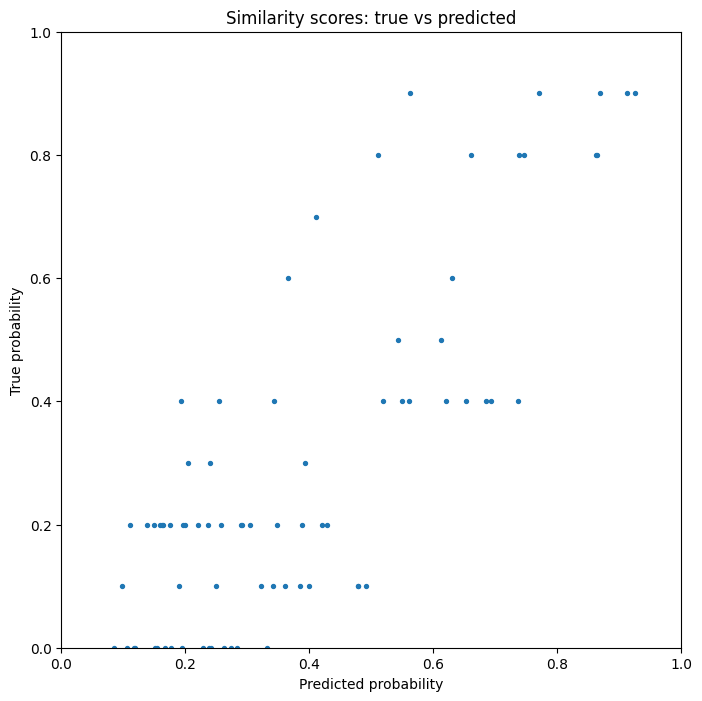

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Create a scatter plot
ax.scatter(predictions.predictions.squeeze(), predictions.label_ids, s=8)

# Add titles and labels
ax.set_title('Similarity scores: true vs predicted')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Show the plot
plt.show()

## Siamese networks and triplet loss

In [20]:
# model definition
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm


In [22]:
# Prepare the dataset with triplets
def create_triplets(df, threshold=0.5):
    triplets = []
    for i, row in df.iterrows():
        anchor = row['candidate_answer']
        
        # Select a positive example: an LLM answer with high plagiarism score
        positive_indices = df[df['plagiarism_score'] > threshold].index
        if not positive_indices.empty:
            positive_index = np.random.choice(positive_indices)
            positive = df.at[positive_index, 'llm_answer']
        else:
            continue  # Skip if no positive example is found
        
        # Select a negative example: an LLM answer with low plagiarism score
        negative_indices = df[df['plagiarism_score'] <= threshold].index
        if not negative_indices.empty:
            negative_index = np.random.choice(negative_indices)
            negative = df.at[negative_index, 'llm_answer']
        else:
            continue  # Skip if no negative example is found
        
        triplets.append((anchor, positive, negative))
    
    return pd.DataFrame(triplets, columns=['anchor', 'positive', 'negative'])


# Tokenization function
def tokenize(batch: Dict[str, Any], tokenizer: PreTrainedTokenizerBase) -> Dict[str, Any]:
    anchor = tokenizer(batch['anchor'], padding=True, truncation=True, return_tensors="pt")
    positive = tokenizer(batch['positive'], padding=True, truncation=True, return_tensors="pt")
    negative = tokenizer(batch['negative'], padding=True, truncation=True, return_tensors="pt")
    return {
        'anchor_input_ids': anchor['input_ids'].squeeze(),
        'anchor_attention_mask': anchor['attention_mask'].squeeze(),
        'positive_input_ids': positive['input_ids'].squeeze(),
        'positive_attention_mask': positive['attention_mask'].squeeze(),
        'negative_input_ids': negative['input_ids'].squeeze(),
        'negative_attention_mask': negative['attention_mask'].squeeze(),
    }
    

# Prepare the final datasets for training
def prepare_dataset(dataset):
    return {
        'anchor_input_ids': dataset['anchor_input_ids'],
        'anchor_attention_mask': dataset['anchor_attention_mask'],
        'positive_input_ids': dataset['positive_input_ids'],
        'positive_attention_mask': dataset['positive_attention_mask'],
        'negative_input_ids': dataset['negative_input_ids'],
        'negative_attention_mask': dataset['negative_attention_mask']
    }


# Define collate function for DataLoader
def collate_fn(batch):
    return {
        'anchor_input_ids': torch.stack([torch.tensor(item['anchor_input_ids']) for item in batch]),
        'anchor_attention_mask': torch.stack([torch.tensor(item['anchor_attention_mask']) for item in batch]),
        'positive_input_ids': torch.stack([torch.tensor(item['positive_input_ids']) for item in batch]),
        'positive_attention_mask': torch.stack([torch.tensor(item['positive_attention_mask']) for item in batch]),
        'negative_input_ids': torch.stack([torch.tensor(item['negative_input_ids']) for item in batch]),
        'negative_attention_mask': torch.stack([torch.tensor(item['negative_attention_mask']) for item in batch])
    }


# Define the Siamese Network class
class SiameseNetwork(nn.Module):
    def __init__(self, model_name):
        super(SiameseNetwork, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state[:, 0, :]  # Use the representation of [CLS] token


# Define the TripletLoss class
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        positive_distance = F.pairwise_distance(anchor, positive, p=2)
        negative_distance = F.pairwise_distance(anchor, negative, p=2)
        loss = torch.relu(positive_distance - negative_distance + self.margin)
        return loss.mean()

In [25]:
# Assuming you have a dataframe `df` with columns 'candidate_answer', 'llm_answer', and 'plagiarism_score'
df = DataFrame(data)
df_triplets = create_triplets(df)
dataset = Dataset.from_pandas(df_triplets)
dataset_dict = DatasetDict({'data': dataset})

# Instantiate the tokenizer
model_ckpt = 'microsoft/codebert-base'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Apply tokenization
dataset_encoded = dataset_dict['data'].map(lambda batch: tokenize(batch, tokenizer), batched=True, batch_size=None)#, remove_columns=['anchor', 'positive', 'negative'])

# Split the tokenized dataset into training and validation sets
train_size = 0.2
data_split = dataset_encoded.train_test_split(test_size=1 - train_size, seed=42)

train_dataset = Dataset.from_dict(prepare_dataset(data_split['train']))
test_dataset = Dataset.from_dict(prepare_dataset(data_split['test']))

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

# Instantiate the model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SiameseNetwork(model_ckpt).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = TripletLoss(margin=1.0)

# Training loop
model.train()
for epoch in tqdm(range(4)):  # Change number of epochs as needed
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        
        anchor_outputs = model(batch['anchor_input_ids'].to(device), batch['anchor_attention_mask'].to(device))
        positive_outputs = model(batch['positive_input_ids'].to(device), batch['positive_attention_mask'].to(device))
        negative_outputs = model(batch['negative_input_ids'].to(device), batch['negative_attention_mask'].to(device))
        
        loss = criterion(anchor_outputs, positive_outputs, negative_outputs)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}')

/Users/alexandre.dias/.pyenv/versions/3.9.13/envs/plagiarism/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/378 [00:00<?, ? examples/s]

 25%|██▌       | 1/4 [09:14<27:44, 554.72s/it]

Epoch 1, Loss: 1.6820170402526855


 50%|█████     | 2/4 [19:30<19:41, 590.71s/it]

Epoch 2, Loss: 0.7623371839523315


 75%|███████▌  | 3/4 [29:44<10:01, 601.35s/it]

Epoch 3, Loss: 0.655194541811943


100%|██████████| 4/4 [39:00<00:00, 585.13s/it]

Epoch 4, Loss: 0.7736387133598328


In [26]:
model.eval()

SiameseNetwork(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Laye

In [27]:
def prepare_input(text, tokenizer):
    encoding = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    return input_ids, attention_mask

def compute_similarity(anchor_text, compare_text, model, tokenizer):
    anchor_input_ids, anchor_attention_mask = prepare_input(anchor_text, tokenizer)
    compare_input_ids, compare_attention_mask = prepare_input(compare_text, tokenizer)
    
    with torch.no_grad():
        anchor_output = model(anchor_input_ids, anchor_attention_mask)
        compare_output = model(compare_input_ids, compare_attention_mask)
    
    similarity = F.cosine_similarity(anchor_output, compare_output)
    return similarity.item()



In [28]:
data_split["test"]

Dataset({
    features: ['anchor', 'positive', 'negative', 'anchor_input_ids', 'anchor_attention_mask', 'positive_input_ids', 'positive_attention_mask', 'negative_input_ids', 'negative_attention_mask'],
    num_rows: 303
})

In [29]:
# Example usage
anchor_text = "def add(a, b): return a + b"
compare_text = "def print_hello_world(): print('hello world')"

similarity_score = compute_similarity(anchor_text, compare_text, model, tokenizer)
print(f'Similarity Score: {similarity_score}')

Similarity Score: 0.9966973066329956


In [30]:
# Compute similarity scores for the test dataset
results = []

for batch in tqdm(test_loader):
    anchor_outputs = model(batch['anchor_input_ids'].to(device), batch['anchor_attention_mask'].to(device))
    positive_outputs = model(batch['positive_input_ids'].to(device), batch['positive_attention_mask'].to(device))
    negative_outputs = model(batch['negative_input_ids'].to(device), batch['negative_attention_mask'].to(device))
    
    with torch.no_grad():
        positive_similarity = F.cosine_similarity(anchor_outputs, positive_outputs).cpu().numpy()
        negative_similarity = F.cosine_similarity(anchor_outputs, negative_outputs).cpu().numpy()
    
    for i in range(len(anchor_outputs)):
        results.append({
            'anchor': batch['anchor_input_ids'][i].cpu().numpy(),
            'positive_similarity': positive_similarity[i],
            'negative_similarity': negative_similarity[i]
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

100%|██████████| 38/38 [13:36<00:00, 21.49s/it]


                                                anchor  positive_similarity  \
0    [0, 50254, 28043, 50118, 35435, 120, 14323, 15...             0.991161   
1    [0, 49179, 44619, 1640, 39006, 43, 6015, 8317,...             0.972400   
2    [0, 47888, 12803, 13360, 25522, 50118, 1437, 5...             0.930107   
3    [0, 42653, 49378, 579, 16637, 10643, 28012, 41...             0.974560   
4    [0, 41975, 30001, 6, 25522, 304, 13360, 35524,...             0.971747   
..                                                 ...                  ...   
298  [0, 35435, 3438, 34965, 2911, 14263, 4771, 272...             0.955246   
299  [0, 41975, 128, 46181, 35, 4825, 12158, 73, 36...             0.941888   
300  [0, 35435, 3438, 34965, 2911, 14263, 4771, 272...             0.932254   
301  [0, 46797, 1215, 8458, 5457, 46679, 3340, 523,...             0.992617   
302  [0, 5499, 3765, 39825, 35, 246, 4, 398, 50118,...             0.987245   

     negative_similarity  
0               0.973718

In [32]:
results_df.describe()

,positive_similarity,negative_similarity
count,303.000000,303.000000
mean,0.967651,0.950894
std,0.023597,0.034736
min,0.850540,0.813169
25%,0.956277,0.930781
50%,0.973614,0.961339
75%,0.986068,0.977350
max,0.998662,0.997254
